Number of unique mice IDs: 249
Duplicate time points found:
    Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
908     g989     Propriva  Female          21          26          0   
909     g989     Propriva  Female          21          26          0   
910     g989     Propriva  Female          21          26          5   
911     g989     Propriva  Female          21          26          5   
912     g989     Propriva  Female          21          26         10   
913     g989     Propriva  Female          21          26         10   
914     g989     Propriva  Female          21          26         15   
915     g989     Propriva  Female          21          26         15   
916     g989     Propriva  Female          21          26         20   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
908           45.000000                 0  
909           45.000000                 0  
910           4

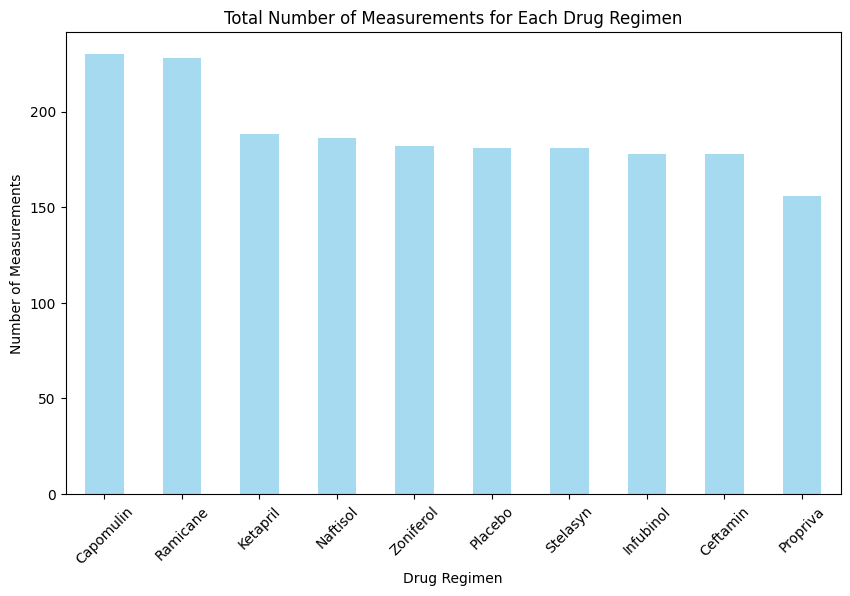

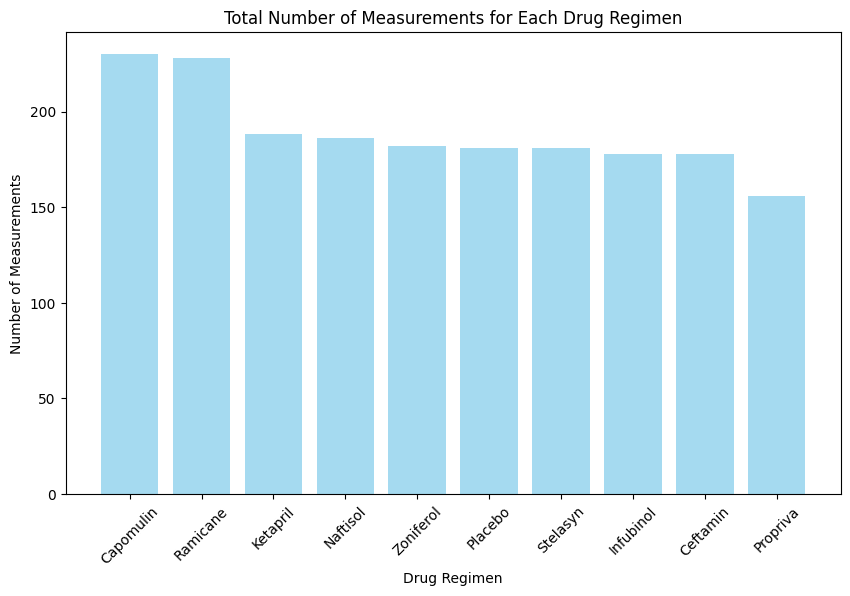

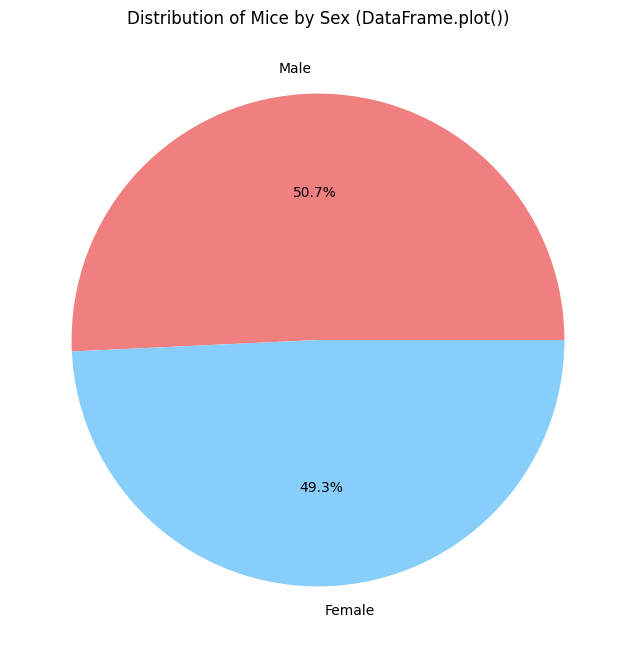

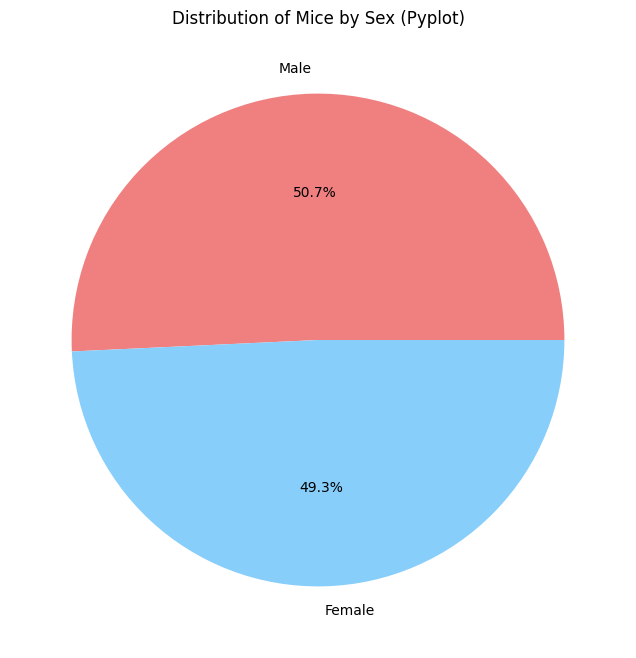

No outliers for Capomulin
No outliers for Ramicane
Outliers for Infubinol:
31    36.321346
Name: Tumor Volume (mm3), dtype: float64
No outliers for Ceftamin


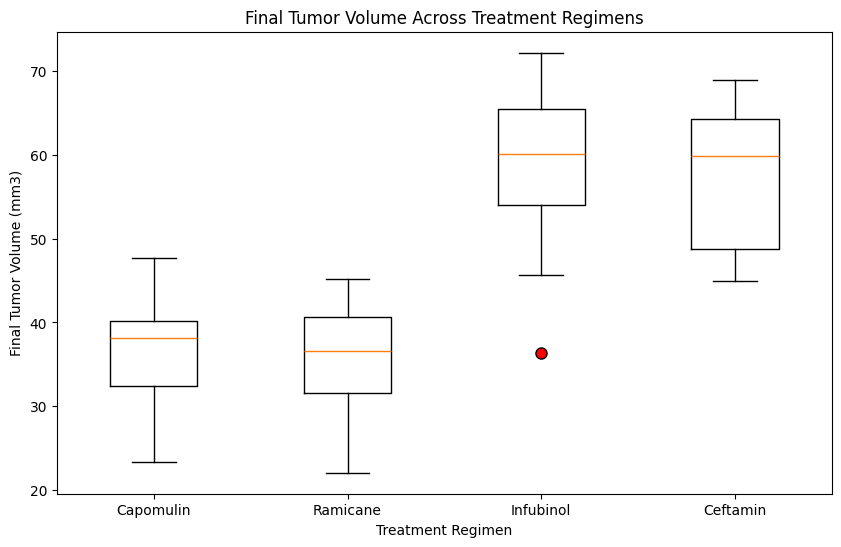

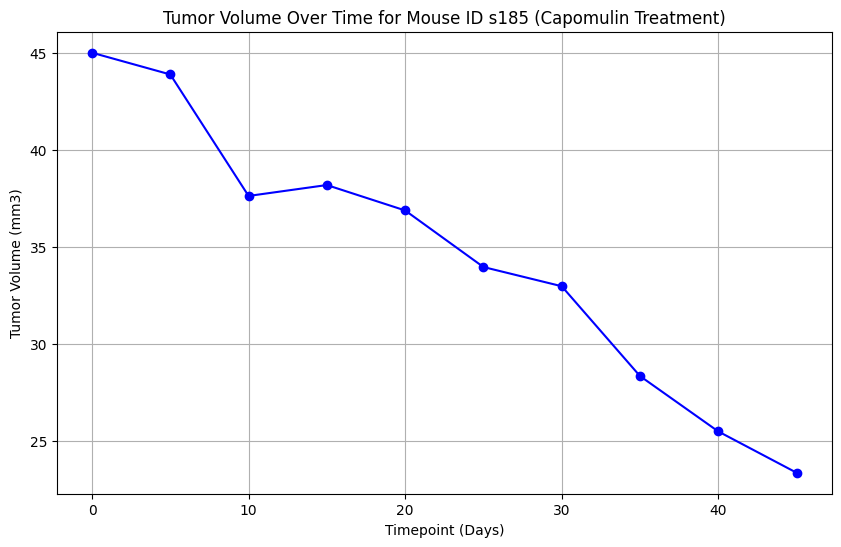

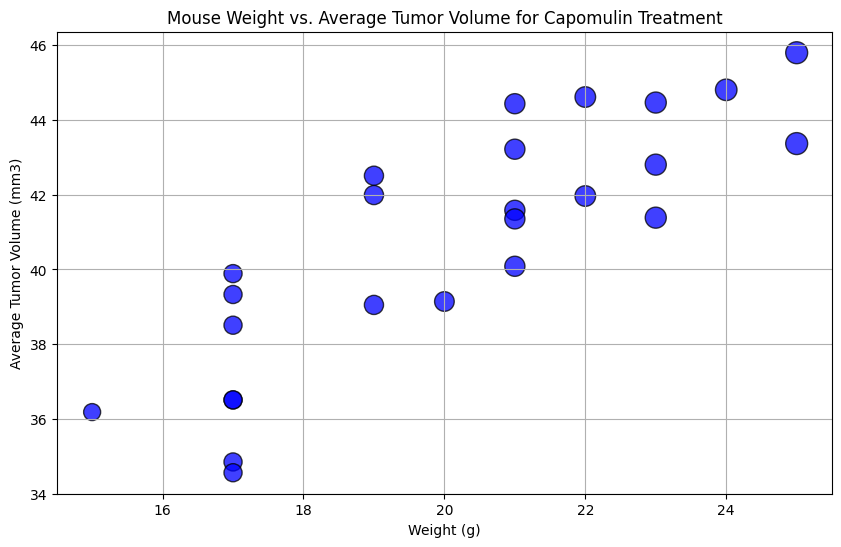

Correlation between mouse weight and average tumor volume for Capomulin regimen: 0.841936342469472


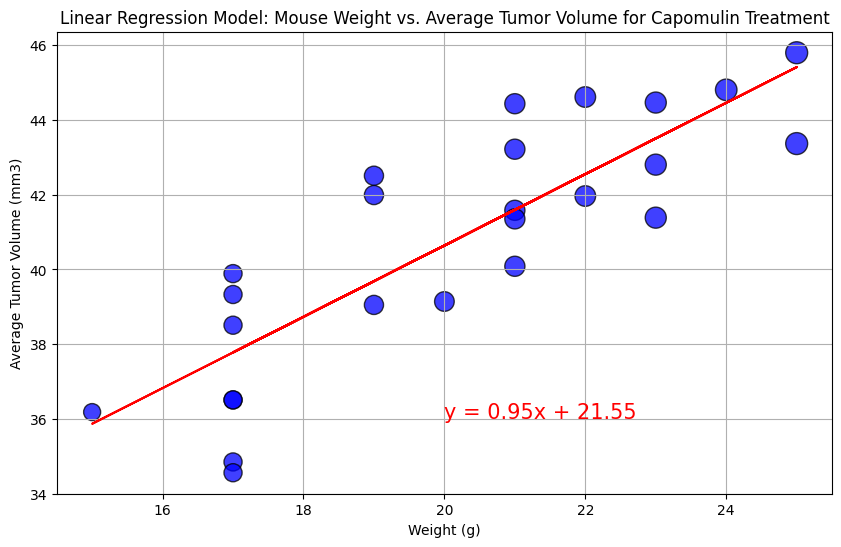

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# Load data
mouse_metadata_path = "/Users/syedshahid/Module 5 Challenge/Pymaceuticals/data/Mouse_metadata.csv"
study_results_path = "/Users/syedshahid/Module 5 Challenge/Pymaceuticals/data/Study_results.csv"
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Merge dataframes
merged_data = pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")

# Display number of unique mice IDs
unique_mice = merged_data["Mouse ID"].nunique()
print(f"Number of unique mice IDs: {unique_mice}")

# Check for duplicate time points
duplicate_timepoints = merged_data[merged_data.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]
if not duplicate_timepoints.empty:
    print("Duplicate time points found:")
    print(duplicate_timepoints)
    # Remove duplicate data
    cleaned_data = merged_data.drop_duplicates(subset=["Mouse ID", "Timepoint"], keep="first")
    # Display updated number of unique mice IDs
    updated_unique_mice = cleaned_data["Mouse ID"].nunique()
    print(f"Updated number of unique mice IDs after removing duplicates: {updated_unique_mice}")
else:
    print("No duplicate time points found.")
    cleaned_data = merged_data

# Generate summary statistics
summary_stats = cleaned_data.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(["mean", "median", "var", "std", "sem"])

# Create bar charts
# Using DataFrame.plot() method
bar_chart_df = cleaned_data["Drug Regimen"].value_counts()
bar_chart_df.plot(kind="bar", color="skyblue", alpha=0.75, rot=45, figsize=(10, 6))
plt.title("Total Number of Measurements for Each Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Measurements")
plt.show()

# Using Matplotlib's pyplot methods
plt.figure(figsize=(10, 6))
plt.bar(bar_chart_df.index, bar_chart_df.values, color="skyblue", alpha=0.75)
plt.title("Total Number of Measurements for Each Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Measurements")
plt.xticks(rotation=45)
plt.show()

# Create pie charts
# Using DataFrame.plot() method
pie_chart_df = cleaned_data["Sex"].value_counts()
pie_chart_df.plot(kind="pie", autopct="%1.1f%%", colors=["lightcoral", "lightskyblue"], figsize=(8, 8))
plt.title("Distribution of Mice by Sex (DataFrame.plot())")
plt.ylabel("")
plt.show()

# Using Matplotlib's pyplot methods
plt.figure(figsize=(8, 8))
plt.pie(pie_chart_df.values, labels=pie_chart_df.index, autopct="%1.1f%%", colors=["lightcoral", "lightskyblue"])
plt.title("Distribution of Mice by Sex (Pyplot)")
plt.show()

# Calculate quartiles, find outliers, and create a box plot
# Create a grouped DataFrame that shows the last (greatest) time point for each mouse
grouped_data = cleaned_data.groupby("Mouse ID").agg({"Timepoint": "max"})
# Merge with original cleaned DataFrame
final_volume_data = pd.merge(grouped_data, cleaned_data, on=["Mouse ID", "Timepoint"], how="inner")

# List of promising treatment regimens
promising_treatments = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create an empty list to hold the tumor volume data
tumor_volume_data = []

# Loop through each drug in the treatment list
for drug in promising_treatments:
    # Locate the rows in the merged DataFrame that correspond to each treatment
    tumor_volume_data.append(final_volume_data.loc[final_volume_data["Drug Regimen"] == drug, "Tumor Volume (mm3)"])

# Determine outliers by using the upper and lower bounds
outliers = []
for data in tumor_volume_data:
    quartiles = data.quantile([0.25, 0.75])
    lower_quartile = quartiles[0.25]
    upper_quartile = quartiles[0.75]
    iqr = upper_quartile - lower_quartile
    lower_bound = lower_quartile - (1.5 * iqr)
    upper_bound = upper_quartile + (1.5 * iqr)
    outliers.append(data.loc[(data < lower_bound) | (data > upper_bound)])

# Print outliers
for i, drug in enumerate(promising_treatments):
    if not outliers[i].empty:
        print(f"Outliers for {drug}:")
        print(outliers[i])
    else:
        print(f"No outliers for {drug}")

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(tumor_volume_data, labels=promising_treatments, flierprops=dict(marker="o", markersize=8, markerfacecolor="red"))
plt.title("Final Tumor Volume Across Treatment Regimens")
plt.xlabel("Treatment Regimen")
plt.ylabel("Final Tumor Volume (mm3)")
plt.show()

# Create a line plot
# Select a single mouse treated with Capomulin
capomulin_data = cleaned_data[cleaned_data["Drug Regimen"] == "Capomulin"]
single_mouse = capomulin_data[capomulin_data["Mouse ID"] == "s185"]

plt.figure(figsize=(10, 6))
plt.plot(single_mouse["Timepoint"], single_mouse["Tumor Volume (mm3)"], marker="o", color="b", linestyle="-")
plt.title("Tumor Volume Over Time for Mouse ID s185 (Capomulin Treatment)")
plt.xlabel("Timepoint (Days)")
plt.ylabel("Tumor Volume (mm3)")
plt.grid(True)
plt.show()

# Create a scatter plot
# Select data for the entire Capomulin treatment regimen
capomulin_data = cleaned_data[cleaned_data["Drug Regimen"] == "Capomulin"]
average_tumor_volume = capomulin_data.groupby("Mouse ID")["Tumor Volume (mm3)"].mean()
mouse_weight = capomulin_data.groupby("Mouse ID")["Weight (g)"].mean()

plt.figure(figsize=(10, 6))
plt.scatter(mouse_weight, average_tumor_volume, marker="o", facecolors="blue", edgecolors="black", s=mouse_weight*10, alpha=0.75)
plt.title("Mouse Weight vs. Average Tumor Volume for Capomulin Treatment")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.grid(True)
plt.show()

# Calculate correlation and regression
correlation = pearsonr(mouse_weight, average_tumor_volume)[0]
print("Correlation between mouse weight and average tumor volume for Capomulin regimen:", correlation)

# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(mouse_weight, average_tumor_volume)
regress_values = mouse_weight * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10, 6))
plt.scatter(mouse_weight, average_tumor_volume, marker="o", facecolors="blue", edgecolors="black", s=mouse_weight*10, alpha=0.75)
plt.plot(mouse_weight, regress_values, "r-")
plt.annotate(line_eq, (20, 36), fontsize=15, color="red")
plt.title("Linear Regression Model: Mouse Weight vs. Average Tumor Volume for Capomulin Treatment")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.grid(True)
plt.show()
